In [0]:
 !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-04-10 11:14:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  61.0MB/s    in 4.7s    

2019-04-10 11:14:50 (50.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!unzip -qq 'tiny-imagenet-200.zip'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten, Dropout, Concatenate
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2,l1
from keras import backend as K
from keras.layers import Activation

Using TensorFlow backend.


In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from keras import metrics
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)
train_datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        rescale = 1./255,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True # randomly flip images
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64,64), color_mode='rgb', 
                                                    batch_size=250, class_mode='categorical', seed=1)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=64, shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [0]:
def create_model(inp_shape=(32,32,3)):
    from keras.models import Sequential
    from keras.layers.advanced_activations import LeakyReLU , ReLU
    from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalMaxPooling2D
    from keras import initializers
    from keras.regularizers import l2
    from keras.layers.merge import concatenate
    from keras.models import Sequential
    from keras.layers.advanced_activations import LeakyReLU , ReLU
    from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalMaxPooling2D
    from keras import initializers
    from keras.regularizers import l2
    from keras.layers.merge import concatenate
    from keras.optimizers import SGD, Adam
    input = Input(shape=inp_shape)

    layer1 = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(input)
    layer1 = BatchNormalization(name='norm_1')(layer1)
    layer1 = ReLU()(layer1)
    layer2 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer1)
    layer2 = BatchNormalization(name='norm_2')(layer2)
    layer2 = ReLU()(layer2)
    layer3 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer2)
    layer3 = BatchNormalization(name='norm_3')(layer3)
    layer3 = ReLU()(layer3)
    #con_1 = concatenate([layer3,layer1],name='con_1')
    layer4 = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_4', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer3)
    layer4 = BatchNormalization(name='norm_4')(layer4)
    layer4 = ReLU()(layer4)
    con_2 = concatenate([layer4,layer1],name='con_2')
    MP_1 = MaxPooling2D(pool_size=(2, 2))(con_2)
    layer6 = Conv2D(128, (1,1), strides=(1,1), padding='same', name='BN1_conv_1x1', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(MP_1)
    layer6 = BatchNormalization(name='BN1_norm_1')(layer6)
    layer6 = ReLU()(layer6)
    #MaxPooling2D(pool_size=(2, 2))(layer11)
    #Block 3
    layer7 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer6)
    layer7 = BatchNormalization(name='norm_6')(layer7)
    layer7 = ReLU()(layer7)
    layer8 = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_7', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer7)
    layer8 = BatchNormalization(name='norm_7')(layer8)
    layer8 = ReLU()(layer8)
    #con_3 =  concatenate([layer6,layer8],name='con_3')
    MP_2 = MaxPooling2D(pool_size=(2, 2))(layer8)
    layer9 = Conv2D(128, (1,1), strides=(1,1), padding='same', name='BN2_conv_1x1', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(MP_2)
    layer9 = BatchNormalization(name='BN2_norm_2')(layer9)
    layer9 = ReLU()(layer9)
    #layer9 = MaxPooling2D(pool_size=(2, 2))(layer9)
    #Block 4
    layer10 = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer9)
    layer10 = BatchNormalization(name='norm_8')(layer10)
    layer10 = ReLU()(layer10)
    layer11 = Conv2D(512, (3,1), strides=(1,1), padding='same', name='conv_9', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer10)
    layer11 = Conv2D(512, (1,3), strides=(1,1), padding='same', name='conv_9a', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer11)
    layer11 = BatchNormalization(name='norm_9')(layer11)
    layer11 = ReLU()(layer11)
    #con_4 = concatenate([layer9,layer6],name='con_4')
    MP_3 = MaxPooling2D(pool_size=(2, 2))(layer11)
    layer12 = Conv2D(256, (1,1), strides=(1,1), padding='same', name='BN3_conv_1x1', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(MP_3)
    layer12 = BatchNormalization(name='BN3_norm_3')(layer12)
    layer12 = ReLU()(layer12)
    layer13 = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_10', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer12)
    layer13 = BatchNormalization(name='norm_10')(layer13)
    layer13 = ReLU()(layer13)
    layer14 = Conv2D(512, (3,1), strides=(1,1), padding='same', name='conv_11', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer13)
    layer14 = Conv2D(512, (1,3), strides=(1,1), padding='same', name='conv_11a', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer14)
    layer14 = BatchNormalization(name='norm_11')(layer14)
    layer14 = ReLU()(layer14)
    con_5 = concatenate([layer12,layer14],name='con_5')
    MP_4 = MaxPooling2D(pool_size=(2, 2))(con_5)
   
    layer15 = Conv2D(512, (1,1), strides=(1,1), padding='same', name='BN4_conv_1x1', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(MP_4)
    layer15 = BatchNormalization(name='BN4_norm_4')(layer15)
    layer15 = ReLU()(layer15)
    layer16 = Conv2D(256, (3,1), strides=(1,1), padding='same', name='conv_12', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer15)
    layer16 = Conv2D(256, (1,3), strides=(1,1), padding='same', name='conv_12a', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer16)
    layer16 = BatchNormalization(name='norm_12')(layer16)
    layer16 = ReLU()(layer16)
    layer17 = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False,kernel_initializer="glorot_normal",
                    kernel_regularizer=l2(5e-4))(layer16)
    layer17 = BatchNormalization(name='norm_13')(layer17)
    layer17 = ReLU()(layer17)
    #con_6 = concatenate([layer15,layer17],name='con_6')
    MP_5 = MaxPooling2D()(layer17)
    layer19 = Conv2D(200, (2,2), strides=(1,1), padding='valid', name='conv_flat', use_bias=False,kernel_initializer="glorot_normal",
                     kernel_regularizer=l2(5e-4))(MP_5)
    layer19 = BatchNormalization(name='norm_flat')(layer19)
    layer19 = Flatten()(layer19)
    output = Activation('softmax')(layer19)
    from keras.models import Model
    model = Model(inputs=[input], outputs=[output])
    #output = Activation('softmax')(layer19)
    return model

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
model = create_model((64,64,3))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 64, 64, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 64, 64, 32)   0           norm_1[0][0]                     
_____________________________________

In [0]:
from keras.optimizers import *
clr_triangular = CyclicLR(base_lr=0.0001,max_lr=0.001,step_size=2000,mode='triangular')
adm=SGD(lr=0.0001, decay=1e-5, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
data_augmentation = True
batch_size = 128
epoch = 2
from keras.utils import np_utils
#call_backs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
filepath="drive/My Drive/weights_folder/weights_best_new2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lr_reducer,clr_triangular]


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=callbacks_list)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    for i in range(epoch):
      model.fit_generator(train_generator,
                          steps_per_epoch=200,
                          validation_data=validation_generator, validation_steps=100,
                          epochs=50, verbose=1, max_q_size=100,callbacks=callbacks_list)
    print("Saving model to disk")
    model.save(filepath)

Using real-time data augmentation.
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=200, validation_data=<keras_pre..., validation_steps=100, epochs=50, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


200/200 [==============================] - 410s 2s/step - loss: 8.0026 - acc: 0.0130 - val_loss: 7.9221 - val_acc: 0.0140

Epoch 00001: val_acc improved from -inf to 0.01401, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 2/50
200/200 [==============================] - 403s 2s/step - loss: 7.7024 - acc: 0.0263 - val_loss: 7.6922 - val_acc: 0.0233

Epoch 00002: val_acc improved from 0.01401 to 0.02328, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 3/50
200/200 [==============================] - 403s 2s/step - loss: 7.4859 - acc: 0.0426 - val_loss: 7.4656 - val_acc: 0.0381

Epoch 00003: val_acc improved from 0.02328 to 0.03810, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 4/50
200/200 [==============================] - 403s 2s/step - loss: 7.2768 - acc: 0.0601 - val_loss: 7.3011 - val_acc: 0.0497

Epoch 00004: val_acc improved from 0.03810 to 0.04975, saving model to drive/My Drive/weights_folder/weights_bes

In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
data_augmentation = True
batch_size = 128
epoch = 1
from keras.utils import np_utils
#call_backs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
filepath="drive/My Drive/weights_folder/weights_best_new2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
adm=SGD(lr=0.001, decay=1e-5, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=callbacks_list)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    for i in range(epoch):
      print("Loading Latest model weights ")
      model = load_model(filepath)
      model.fit_generator(train_generator,
                          steps_per_epoch=200,
                          validation_data=validation_generator, validation_steps=100,
                          epochs=15, verbose=1, max_q_size=100,callbacks=callbacks_list)
    print("Saving model to disk")
    model.save(filepath)

Using real-time data augmentation.
Loading Latest model weights 
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=200, validation_data=<keras_pre..., validation_steps=100, epochs=15, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


200/200 [==============================] - 411s 2s/step - loss: 3.4853 - acc: 0.5798 - val_loss: 4.4716 - val_acc: 0.3752

Epoch 00001: val_acc improved from -inf to 0.37516, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 2/15
200/200 [==============================] - 390s 2s/step - loss: 3.4897 - acc: 0.5785 - val_loss: 4.4638 - val_acc: 0.3730

Epoch 00002: val_acc did not improve from 0.37516
Epoch 3/15
200/200 [==============================] - 390s 2s/step - loss: 3.4703 - acc: 0.5824 - val_loss: 4.4922 - val_acc: 0.3681

Epoch 00003: val_acc did not improve from 0.37516
Epoch 4/15
200/200 [==============================] - 389s 2s/step - loss: 3.4827 - acc: 0.5791 - val_loss: 4.4886 - val_acc: 0.3693

Epoch 00004: val_acc did not improve from 0.37516
Epoch 5/15
200/200 [==============================] - 390s 2s/step - loss: 3.4597 - acc: 0.5847 - val_loss: 4.4960 - val_acc: 0.3759

Epoch 00005: val_acc improved from 0.37516 to 0.37594, saving model to d

In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
data_augmentation = True
batch_size = 128
epoch = 1
from keras.utils import np_utils
#call_backs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
filepath="drive/My Drive/weights_folder/weights_best_new2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,clr_triangular,lr_reducer]
adm=SGD(lr=0.001, decay=1e-5, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=callbacks_list)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    for i in range(epoch):
      print("Loading Latest model weights ")
      model = load_model(filepath)
      model.fit_generator(train_generator,
                          steps_per_epoch=200,
                          validation_data=validation_generator, validation_steps=100,
                          epochs=50, verbose=1, max_q_size=100,callbacks=callbacks_list)
    print("Saving model to disk")
    model.save(filepath)

Using real-time data augmentation.
Loading Latest model weights 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=200, validation_data=<keras_pre..., validation_steps=100, epochs=50, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


200/200 [==============================] - 394s 2s/step - loss: 4.0358 - acc: 0.4452 - val_loss: 4.5666 - val_acc: 0.3470

Epoch 00001: val_acc improved from -inf to 0.34698, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 2/50
200/200 [==============================] - 389s 2s/step - loss: 4.0719 - acc: 0.4321 - val_loss: 4.4832 - val_acc: 0.3523

Epoch 00002: val_acc improved from 0.34698 to 0.35233, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 3/50
200/200 [==============================] - 389s 2s/step - loss: 3.9942 - acc: 0.4475 - val_loss: 4.4549 - val_acc: 0.3708

Epoch 00003: val_acc improved from 0.35233 to 0.37078, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 4/50
200/200 [==============================] - 389s 2s/step - loss: 3.9366 - acc: 0.4576 - val_loss: 4.4605 - val_acc: 0.3588

Epoch 00004: val_acc did not improve from 0.37078
Epoch 5/50
200/200 [==============================] - 389s 2s/

In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)
train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64,64), color_mode='rgb', 
                                                    batch_size=250, class_mode='categorical', seed=1)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=64, shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
data_augmentation = True
batch_size = 128
epoch = 1
from keras.utils import np_utils
#call_backs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
filepath="drive/My Drive/weights_folder/weights_best_new2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,clr_triangular,lr_reducer]
adm=SGD(lr=0.01, decay=1e-5, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)
print("Loading Latest model weights ")
model = load_model(filepath)
model.fit_generator(train_generator,
                    steps_per_epoch=200,
                    validation_data=validation_generator, validation_steps=100,
                    epochs=10, verbose=1, max_q_size=100,callbacks=callbacks_list)
print("Saving model to disk")
model.save(filepath)


Loading Latest model weights 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=200, validation_data=<keras_pre..., validation_steps=100, epochs=10, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/10
200/200 [==============================] - 393s 2s/step - loss: 2.9699 - acc: 0.6279 - val_loss: 3.9134 - val_acc: 0.4391

Epoch 00001: val_acc improved from -inf to 0.43906, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 2/10
200/200 [==============================] - 388s 2s/step - loss: 2.9156 - acc: 0.6415 - val_loss: 3.8544 - val_acc: 0.4462

Epoch 00002: val_acc improved from 0.43906 to 0.44616, saving model to drive/My Drive/weights_folder/weights_best_new2.h5
Epoch 3/10
200/200 [==============================] - 388s 2s/step - loss: 2.8190 - acc: 0.6690 - val_loss: 3.9059 - val_acc: 0.4431

Epoch 00003: val_acc did not improve from 0.44616
Epoch 4/10
200/200 [==============================] - 388s 2s/step - loss: 2.8474 - acc: 0.6599 - val_loss: 3.8640 - val_acc: 0.4443

Epoch 00004: val_acc did not improve from 0.44616
Epoch 5/10
200/200 [==============================] - 389s 2s/step - loss: 2.7270 - acc: 0.6954 - val_loss: 3.9088 - val_ac

In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
data_augmentation = True
batch_size = 128
epoch = 1
from keras.utils import np_utils
#Y_train = np_utils.to_categorical(y_train, 200)
#Y_test = np_utils.to_categorical(y_test, 200)

#call_backs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
#checkpoint_path = "drive/My Drive/weights_folder/cp-{epoch:01d}.h5"
#checkpoint_dir = os.path.dirname(checkpoint_path)
filepath="drive/My Drive/weights_folder/weights_best_new.h5"
#checkpoint_dir = os.path.dirname(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lr_reducer,clr_triangular]
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,period=2)
#model = create_model((64,64,3))


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=callbacks_list)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    #datagen.fit(X_train)
    
    # Fit the model on the batches generated by datagen.flow().
    #model.load_weights(latest)
    #model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
    #                      steps_per_epoch=X_train.shape[0] // batch_size,
    #                     validation_data=(X_test, Y_test),
    #                     epochs=1, verbose=1,callbacks=callbacks_list)
    
    #model = load_model(filepath)
    for i in range(epoch):
      print("Loading Latest model weights ")
      model = load_model(filepath)
      #model.fit_generator(train_generator, epochs=20, steps_per_epoch=500, validation_steps=100, validation_data=validation_generator)
      model.fit_generator(train_generator,
                            steps_per_epoch=200,
                            validation_data=validation_generator, validation_steps=100,
                            epochs=10, verbose=1, max_q_size=100,callbacks=callbacks_list)
      #model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)
      #score = model.evaluate_generator(validation_generator,steps=10, verbose=1)
      #print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
      print("Saving model to disk")
      model.save(filepath)


Using real-time data augmentation.
Loading Latest model weights 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=200, validation_data=<keras_pre..., validation_steps=100, epochs=10, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


200/200 [==============================] - 426s 2s/step - loss: 1.4088 - acc: 0.8018 - val_loss: 2.8421 - val_acc: 0.4911

Epoch 00001: val_acc improved from -inf to 0.49109, saving model to drive/My Drive/weights_folder/weights_best_new.h5
Epoch 2/10
200/200 [==============================] - 421s 2s/step - loss: 1.3282 - acc: 0.8235 - val_loss: 2.8523 - val_acc: 0.4948

Epoch 00002: val_acc improved from 0.49109 to 0.49480, saving model to drive/My Drive/weights_folder/weights_best_new.h5
Epoch 3/10
200/200 [==============================] - 421s 2s/step - loss: 1.2984 - acc: 0.8306 - val_loss: 2.8566 - val_acc: 0.4980

Epoch 00003: val_acc improved from 0.49480 to 0.49795, saving model to drive/My Drive/weights_folder/weights_best_new.h5
Epoch 4/10
200/200 [==============================] - 421s 2s/step - loss: 1.2459 - acc: 0.8452 - val_loss: 2.8379 - val_acc: 0.4972

Epoch 00004: val_acc did not improve from 0.49795
Epoch 5/10
200/200 [==============================] - 421s 2s/ste

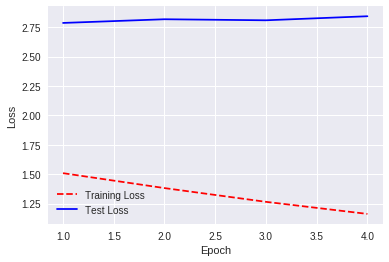

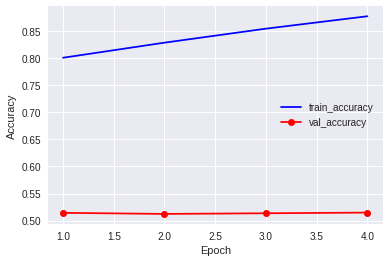

In [0]:
#from keras.callbacks import History 
#Get training and test loss histories

training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

train_accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']
epoch_count = range(1, len(val_accuracy) + 1)
plt.plot(epoch_count, train_accuracy, 'b-')
plt.plot(epoch_count, val_accuracy, 'r-o')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

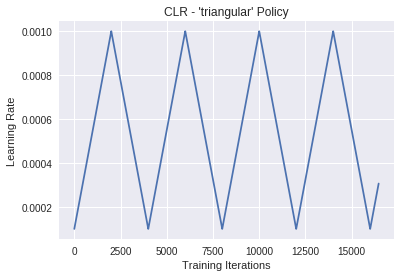

In [0]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [0]:
class_dictionary = validation_generator.class_indices

In [0]:
model.evaluate_generator(generator=validation_generator,steps=1000)

NameError: ignored

In [0]:
validation_generator.reset()
pred=model.predict_generator(validation_generator,verbose=1)